# SIFT + BoW

In [ ]:
! pip install PyWavelets
#! pip install scikit-image

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pywt
import numpy as np
from skimage import exposure
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## 0. Load the data

Create the train and test datasets. To do so, we must extract the files from the folders. The images will be selected ramdomly.

In [98]:
# Load the images from the folders
dataset_info = {}
filenames = {}
animals = os.listdir('animals')
for animal in animals:
    folder_path = f'animals/{animal}'
    filenames[animal] = os.listdir(folder_path)
    number_total_imgs = len(filenames[animal])
    number_train_imgs = number_total_imgs * 91 // 100
    number_test_imgs = number_total_imgs - number_train_imgs
    dataset_info[animal] = {'total': number_total_imgs, 'train': number_train_imgs, 'test': number_test_imgs}

In [99]:
dataset_info

{'Asian Elephant': {'total': 140, 'train': 127, 'test': 13},
 'Asiatic Golden Cat': {'total': 113, 'train': 102, 'test': 11},
 'Asiatic Lion': {'total': 160, 'train': 145, 'test': 15},
 'Bengal Fox': {'total': 140, 'train': 127, 'test': 13},
 'Chinkara': {'total': 148, 'train': 134, 'test': 14},
 'Chital': {'total': 165, 'train': 150, 'test': 15},
 'Golden Langur': {'total': 122, 'train': 111, 'test': 11},
 'Honey Badger': {'total': 110, 'train': 100, 'test': 10},
 'Indian Cobra': {'total': 122, 'train': 111, 'test': 11},
 'Indian Leopard': {'total': 125, 'train': 113, 'test': 12},
 'Mugger Crocodile': {'total': 145, 'train': 131, 'test': 14},
 'Red Panda': {'total': 130, 'train': 118, 'test': 12},
 'Ruddy Mongoose': {'total': 187, 'train': 170, 'test': 17},
 'Striped Hyena': {'total': 124, 'train': 112, 'test': 12},
 'Wild Boar': {'total': 141, 'train': 128, 'test': 13}}

Assing randomly the images to each dataset according to the size of the train and test datasets

In [ ]:
for animal in animals:
    random.shuffle(filenames[animal])

91% to train, 9% for testing

## 1. Preprocess the images

In [5]:
def show_image(img_path):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [9]:
def preprocess_image(image_path):
  """
  Preprocess an image

  Args:
    image_path: The path to the image to preprocess

  Returns:
    The preprocessed image
  """
  # Load
  image = cv2.imread(image_path)

  # Color conversion
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Normalize
  image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

  # Resize
  image = cv2.resize(image, (224, 224))
  return image

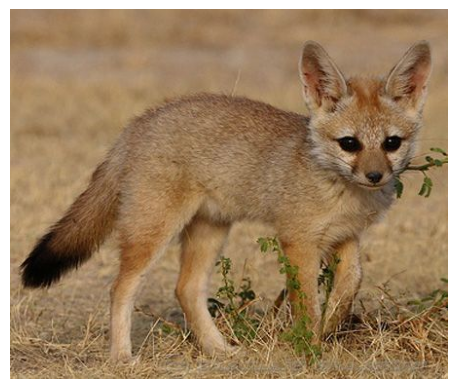

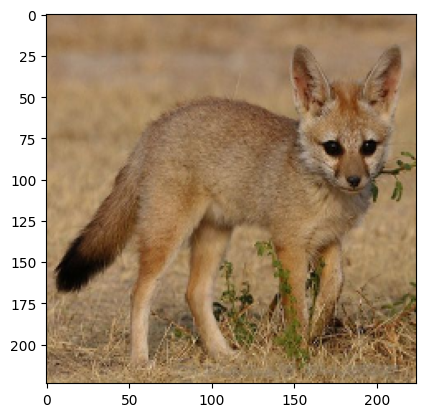

In [ ]:
img_path = 'animals/Bengal Fox/Bengal Fox (2).jpg'
show_image(img_path)
img = preprocess_image(img_path)
plt.imshow(img)


### 2.3 SIFT + Bag of Words

In [ ]:
# Number of visual words for Bag of Words
n_clusters = 100  

# Function to extract SIFT descriptors from an image
def sift_descriptors(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((1, 128))
    return descriptors

# Load dataset and collect all descriptors for k-means clustering
def load_descriptors_for_kmeans(dataset_path):
    descriptors_list = []
    animals = os.listdir(dataset_path)
    for animal in animals:
        folder_path = os.path.join(dataset_path, animal)
        if os.path.isdir(folder_path):
            filenames = os.listdir(folder_path)
            for filename in filenames:
                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: The image {filename} could not be loaded.")
                    continue
                
                descriptors = sift_descriptors(image)
                descriptors_list.extend(descriptors)
    
    return np.array(descriptors_list)


# Create histograms based on visual words (BoW representation)
def create_bow_histograms(dataset_path, kmeans):
    features_list = []
    labels = []
    animals = os.listdir(dataset_path)
    
    for animal in animals:
        folder_path = os.path.join(dataset_path, animal)
        if os.path.isdir(folder_path):
            filenames = os.listdir(folder_path)
            for filename in filenames:
                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: The image {filename} could not be loaded.")
                    continue
                
                descriptors = sift_descriptors(image)
                
                # Predict visual words for each descriptor
                words = kmeans.predict(descriptors)
                
                # Create histogram of visual words
                hist, _ = np.histogram(words, bins=np.arange(n_clusters+1))
                
                # Append histogram and label
                features_list.append(hist)
                labels.append(animal)
    
    return np.array(features_list), np.array(labels)

In [ ]:
# Path to your dataset
dataset_path = 'animals'  # Update with your dataset path

# Step 1: Collect all descriptors for k-means clustering
print("Extracting descriptors for k-means clustering...")
all_descriptors = load_descriptors_for_kmeans(dataset_path)

# Step 2: Perform k-means clustering to create visual words
print("Performing k-means clustering...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors)

# Step 3: Represent images with BoW histograms
print("Creating Bag of Words histograms...")
features, labels = create_bow_histograms(dataset_path, kmeans)

# Step 4: Fit StandardScaler on all features (after histogram creation)
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [26]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 5: Train a classifier (Random Forest as an example)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Test the classifier on the test set
y_pred = classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.42

Classification Report:
                    precision    recall  f1-score   support

    Asian Elephant       0.26      0.52      0.35        27
Asiatic Golden Cat       0.35      0.52      0.42        21
      Asiatic Lion       0.29      0.26      0.28        34
        Bengal Fox       0.46      0.30      0.36        37
          Chinkara       0.37      0.39      0.38        28
            Chital       0.42      0.32      0.37        34
     Golden Langur       0.50      0.55      0.52        22
      Honey Badger       0.58      0.44      0.50        16
      Indian Cobra       0.46      0.32      0.38        19
    Indian Leopard       0.69      0.69      0.69        29
  Mugger Crocodile       0.38      0.38      0.38        26
         Red Panda       0.55      0.57      0.56        28
    Ruddy Mongoose       0.44      0.49      0.47        41
     Striped Hyena       0.25      0.30      0.27        20
         Wild Boar       0.50      0.25      0.33        32


In [ ]:
import joblib

# Paths to save the models and data
kmeans_path = 'SIFT_BoW/kmeans_model.joblib'
scaler_path = 'SIFT_BoW/scaler.joblib'
classifier_path = 'SIFT_BoW/classifier.joblib'
features_path = 'SIFT_BoW/features.npy'
labels_path = 'SIFT_BoW/labels.npy'

# Function to save models and data
def save_models_and_data(kmeans, scaler, classifier, features, labels):
    joblib.dump(kmeans, kmeans_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(classifier, classifier_path)
    np.save(features_path, features)
    np.save(labels_path, labels)
    print("Models and data saved successfully.")

# Function to load models and data
def load_models_and_data():
    kmeans = joblib.load(kmeans_path)
    scaler = joblib.load(scaler_path)
    classifier = joblib.load(classifier_path)
    features = np.load(features_path)
    labels = np.load(labels_path)
    print("Models and data loaded successfully.")
    return kmeans, scaler, classifier, features, labels

save_models_and_data(kmeans, scaler, classifier, features, labels)

Models and data saved successfully.
